# Домашнее задание 3. Сверточные нейронные сети

In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd

from keras.datasets import cifar10
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model 

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

from keras import callbacks

## Задание


1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10

2. оценить рост точности при увеличении ширины сети (больше фильтров)

3. оценить рост точности при увеличении глубины сети (больше слоев)

4. *сравнить с точностью полносвязной сети для этой выборки

## План решения

[0. Загрузка данных](#section_0)

[1. Подготовка данных](#section_1)

[2. Рукописная сверточная нейронная сеть](#section_2)

[3. Оценка роста точности нейронной сети при увеличении ширины (количества фильтров) сети](#section_3)

[4. Оценка роста точности нейронной сети при увеличении глубины (количества слоев) сети](#section_4)
    
[5*. Полносвязная нейронная сеть](#section_5)

[6. Выводы](#section_6)

## 0. Загрузка данных<a id='section_0'></a>

In [2]:
# загрузка тренировочных и тестовых данных

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label is [0]


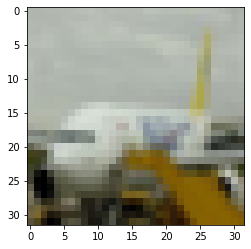

In [4]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is {y_train[ind]}')

## 1. Подготовка данных<a id='section_1'></a>

In [5]:
# установка параметров
num_classes = 10
num_predictions = 20
model_name = 'keras_cifar10'

In [6]:
# Нормировка
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.min(), X_train.max()

(0.0, 1.0)

In [7]:
X_train

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [8]:
# преобразование меток класса к категориальному типу
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [9]:
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## 2. Рукописная сверточная нейронная сеть<a id='section_2'></a>

In [10]:
#параметры сети
batch_size = 16
epochs = 20

In [11]:
# инициализация модели
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
#сверточный слой
model.add(Conv2D(32, #количество фильтров
                 (3, 3), #размер фильтра
                 padding='same', #рамка
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu')) #применяется к матрице-свертке
#сверточный слой
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
#пуллинг слой
model.add(MaxPooling2D(pool_size=(2, 2))) #размер фильтра пуллинга (подвыборки) с оператором max
model.add(Dropout(0.25)) #доля входных блоков для исключения при обучении

#сверточный слой
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
#сверточный слой
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
#пуллинг слой
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten()) 
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [12]:
%%time

#обучение модели
hist = model.fit(X_train, y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(X_test, y_test),
                 verbose=1)

#метрики модели
test_loss, test_metric = model.evaluate(X_test, y_test)
print(f"Test loss {test_loss:.4f}, accuracy {test_metric:.2f}%")

Epoch 1/20
3125/3125 [==============================] - 121s 39ms/step - loss: 1.9661 - accuracy: 0.2715 - val_loss: 1.6247 - val_accuracy: 0.4139
Epoch 2/20
3125/3125 [==============================] - 120s 38ms/step - loss: 1.5973 - accuracy: 0.4163 - val_loss: 1.4359 - val_accuracy: 0.4686
Epoch 3/20
3125/3125 [==============================] - 120s 38ms/step - loss: 1.4209 - accuracy: 0.4846 - val_loss: 1.3766 - val_accuracy: 0.5121
Epoch 4/20
3125/3125 [==============================] - 119s 38ms/step - loss: 1.3037 - accuracy: 0.5334 - val_loss: 1.2320 - val_accuracy: 0.5610
Epoch 5/20
3125/3125 [==============================] - 119s 38ms/step - loss: 1.2177 - accuracy: 0.5652 - val_loss: 1.1058 - val_accuracy: 0.6099
Epoch 6/20
3125/3125 [==============================] - 119s 38ms/step - loss: 1.1382 - accuracy: 0.5942 - val_loss: 1.0402 - val_accuracy: 0.6320
Epoch 7/20
3125/3125 [==============================] - 119s 38ms/step - loss: 1.0662 - accuracy: 0.6229 - val_loss: 0

In [13]:
#оценка качества модели
train_accuracy = hist.history['accuracy'][-1]
test_accuracy = hist.history['val_accuracy'][-1]

train_accuracy, test_accuracy

(0.7829200029373169, 0.7857999801635742)

In [14]:
#датафрейм с метриками
CNN_result = pd.DataFrame({'Model': ['CNN'], 
                           'Train accuracy': [train_accuracy], 
                           'Test accuracy': [test_accuracy]})

CNN_result

,Model,Train accuracy,Test accuracy
0,CNN,0.78292,0.7858


**Вывод:** 

1) обучение модели занимает большое время (требуются небольшие количества эпох и батчей), 

2) метрика на валидации растет не монотонно,

3) модель легко переобучается, требуется длительная настройка параметров сети.

## 3. Оценка роста точности нейронной сети при увеличении ширины (количества фильтров) сети <a id='section_3'></a>

Увеличим число фильтров нa сверточных слоях модели из пункта 2 в два раза

In [15]:
# инициализация модели
model2 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
#сверточный слой
model2.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model2.add(Activation('relu')) 
#сверточный слой
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
#пулинг(подвыбока)-слой
model2.add(MaxPooling2D(pool_size=(2, 2))) 
model2.add(Dropout(0.25)) 

#сверточный слой
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
#сверточный слой
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
#пуллинг слой
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# полносвязные слои нейронной сети
model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

# компиляция модели
model2.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [16]:
%%time


#обучение модели
hist2 = model2.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          verbose=1)

#метрики модели
test_loss_2, test_metric_2 = model2.evaluate(X_test, y_test)
print(f"Test loss {test_loss_2:.4f}, accuracy {test_metric_2:.2f}%")

Epoch 1/20
3125/3125 [==============================] - 253s 81ms/step - loss: 1.9572 - accuracy: 0.2801 - val_loss: 1.7048 - val_accuracy: 0.3721
Epoch 2/20
3125/3125 [==============================] - 249s 80ms/step - loss: 1.5683 - accuracy: 0.4300 - val_loss: 1.3527 - val_accuracy: 0.5115
Epoch 3/20
3125/3125 [==============================] - 253s 81ms/step - loss: 1.3567 - accuracy: 0.5093 - val_loss: 1.1929 - val_accuracy: 0.5744
Epoch 4/20
3125/3125 [==============================] - 257s 82ms/step - loss: 1.2213 - accuracy: 0.5654 - val_loss: 1.0862 - val_accuracy: 0.6115
Epoch 5/20
3125/3125 [==============================] - 256s 82ms/step - loss: 1.1145 - accuracy: 0.6049 - val_loss: 1.0056 - val_accuracy: 0.6465
Epoch 6/20
3125/3125 [==============================] - 253s 81ms/step - loss: 1.0295 - accuracy: 0.6343 - val_loss: 0.9306 - val_accuracy: 0.6742
Epoch 7/20
3125/3125 [==============================] - 255s 82ms/step - loss: 0.9538 - accuracy: 0.6620 - val_loss: 0

In [17]:
#оценка качества модели
train_accuracy_2 = hist2.history['accuracy'][-1]
test_accuracy_2 = hist2.history['val_accuracy'][-1]

train_accuracy_2, test_accuracy_2

(0.840939998626709, 0.796999990940094)

In [18]:
#датафрейм с метриками
CNN_result = CNN_result.append({'Model': 'СNN_more_filters', 
                                'Train accuracy': train_accuracy_2, 
                                'Test accuracy': test_accuracy_2},
                                 ignore_index=True)

CNN_result.sort_values(by='Test accuracy',ascending=False)

,Model,Train accuracy,Test accuracy
1,СNN_more_filters,0.84094,0.7970
0,CNN,0.78292,0.7858


**Вывод:** 

1) обучение модели занимает большее время, чем модели с меньшим числом фильтров, 

2) метрика на валидации растет не монотонно,

3) при увеличении числа фильтров метрика accuracy на тесте увеличивается (но растет и переобучение).

## 4. Оценка роста точности нейронной сети при увеличении глубины (количества слоев) сети<a id='section_4'></a>

Увеличим число слоев модели из пункта 2

In [19]:
# инициализация модели
model3 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
#сверточный слой
model3.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model3.add(Activation('relu')) 
#сверточный слой
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
#пуллинг(подвыбока)-слой 
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

#сверточный слой
model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
#сверточный слой
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
#пулинг слой
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

#сверточный слой
model3.add(Conv2D(128, (3, 3), padding='same'))
model3.add(Activation('relu'))
#сверточный слой
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
#пулинг слой
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# полносвязные слои нейронной сети
model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

# компиляция модели
model3.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [20]:
%%time


#обучение модели
hist3 = model3.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          verbose=1)

#метрики модели
test_loss_3, test_metric_3 = model3.evaluate(X_test, y_test)
print(f"Test loss {test_loss_3:.4f}, accuracy {test_metric_3:.2f}%")

Epoch 1/20
3125/3125 [==============================] - 119s 38ms/step - loss: 2.0957 - accuracy: 0.2038 - val_loss: 1.8471 - val_accuracy: 0.3246
Epoch 2/20
3125/3125 [==============================] - 118s 38ms/step - loss: 1.7388 - accuracy: 0.3517 - val_loss: 1.5341 - val_accuracy: 0.4337
Epoch 3/20
3125/3125 [==============================] - 118s 38ms/step - loss: 1.5300 - accuracy: 0.4347 - val_loss: 1.4443 - val_accuracy: 0.4697
Epoch 4/20
3125/3125 [==============================] - 118s 38ms/step - loss: 1.3842 - accuracy: 0.4952 - val_loss: 1.1995 - val_accuracy: 0.5594
Epoch 5/20
3125/3125 [==============================] - 118s 38ms/step - loss: 1.2729 - accuracy: 0.5423 - val_loss: 1.1222 - val_accuracy: 0.6030
Epoch 6/20
3125/3125 [==============================] - 118s 38ms/step - loss: 1.1832 - accuracy: 0.5772 - val_loss: 1.1180 - val_accuracy: 0.6077
Epoch 7/20
3125/3125 [==============================] - 118s 38ms/step - loss: 1.1078 - accuracy: 0.6069 - val_loss: 0

In [21]:
#оценка качества модели
train_accuracy_3 = hist3.history['accuracy'][-1]
test_accuracy_3 = hist3.history['val_accuracy'][-1]

train_accuracy_3, test_accuracy_3

(0.7856199741363525, 0.79339998960495)

In [22]:
#датафрейм с метриками
CNN_result = CNN_result.append({'Model': 'СNN_more_layers', 
                                'Train accuracy': train_accuracy_3, 
                                'Test accuracy': test_accuracy_3},
                                 ignore_index=True)

CNN_result.sort_values(by='Test accuracy',ascending=False)

,Model,Train accuracy,Test accuracy
1,СNN_more_filters,0.84094,0.7970
2,СNN_more_layers,0.78562,0.7934
0,CNN,0.78292,0.7858


**Вывод:** 

1) обучение модели занимает большее время, чем модели с меньшим числом слоев, 

2) метрика на валидации растет не монотонно,

3) при увеличении числа слоев метрика accuracy на тесте увеличивается (меньше, чем при увеличении фильтров, но зато и переобучение меньше).

## 5*. Полносвязная нейронная сеть<a id='section_5'></a>

In [23]:
#инициализация модели
model_ffnn = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_ffnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                98336     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 101,098
Trainable params: 101,098
Non-trainable params: 0
_________________________________________________________________


In [24]:
#компиляция модели
model_ffnn.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
#обучение модели
hist_ffnn = model_ffnn.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1, 
          validation_data=(X_test, y_test))

Epoch 1/20
3125/3125 [==============================] - 4s 1ms/step - loss: 1.9003 - accuracy: 0.3095 - val_loss: 1.7546 - val_accuracy: 0.3734
Epoch 2/20
3125/3125 [==============================] - 3s 1ms/step - loss: 1.7248 - accuracy: 0.3838 - val_loss: 1.6876 - val_accuracy: 0.4011
Epoch 3/20
3125/3125 [==============================] - 3s 1ms/step - loss: 1.6546 - accuracy: 0.4074 - val_loss: 1.6211 - val_accuracy: 0.4237
Epoch 4/20
3125/3125 [==============================] - 3s 1ms/step - loss: 1.6051 - accuracy: 0.4294 - val_loss: 1.5966 - val_accuracy: 0.4290
Epoch 5/20
3125/3125 [==============================] - 3s 1ms/step - loss: 1.5712 - accuracy: 0.4396 - val_loss: 1.5821 - val_accuracy: 0.4369
Epoch 6/20
3125/3125 [==============================] - 3s 1ms/step - loss: 1.5444 - accuracy: 0.4505 - val_loss: 1.5395 - val_accuracy: 0.4496
Epoch 7/20
3125/3125 [==============================] - 3s 1ms/step - loss: 1.5233 - accuracy: 0.4566 - val_loss: 1.5425 - val_accuracy:

In [26]:
#оценка качества модели
train_accuracy_ffnn = hist_ffnn.history['accuracy'][-1]
test_accuracy_ffnn = hist_ffnn.history['val_accuracy'][-1]

train_accuracy_ffnn, test_accuracy_ffnn

(0.5107799768447876, 0.48410001397132874)

In [27]:
#датафрейм с метриками
CNN_result = CNN_result.append({'Model': 'FFNN', 
                                'Train accuracy': train_accuracy_ffnn, 
                                'Test accuracy': test_accuracy_ffnn},
                                 ignore_index=True)

CNN_result.sort_values(by='Test accuracy',ascending=False)

,Model,Train accuracy,Test accuracy
1,СNN_more_filters,0.84094,0.7970
2,СNN_more_layers,0.78562,0.7934
0,CNN,0.78292,0.7858
3,FFNN,0.51078,0.4841


## 6. Выводы<a id='section_6'></a>

На основе пунктов 2--5 можно сформулировать следующие выводы:

1. полносвязная нейронная сеть обучается быстрее сверточной, 

2. метрика accuracy на тесте у полносвязной нейронной сети хуже, чем у сверточной,

3. при увеличении числа фильтров/слоев сверточной нейронной сети метрика accuracy на тесте увеличивается,

4. для увеличения метрики accuracy на тесте у нейронной сети необходимо:

   - сначала увеличивать числа фильтров, при этом вырастет переобучение, 
   
   - затем увеличить число слоев, чтобы снизить переобучение;

5. лучшие показатели метрики accuracy у нейронной сети с большим числом фильтров.